## Cykelhastigheds data 
Dette er et projekt lavet for Københavns kommunes trafikenhed, hvor vi undersøger cykelhastighederne for tællekamera, som måler cykelhastighed. 
Målet med denne undersøgelse er at finde ud af, hvad den reele cykelhastighed er, så vi dermed bedre kan optimere de grønne cykelbølger. 

For bedre at kunne forstå den data jeg ser skal jeg 
- Gå ind på maps og finde ud af, hvor langt før/efter et lydkryds sensoren er. 
- Give en flowscore på 1 - 5. Denne flowscorer skal beskrive, hvor frit flowet er en scorer på 1 vil sige at der er meget trængt på cykelstien, mens 5 betyder at der er free flow på cykelstien. 
- Også en beskrivelse af cykelstistypen: small, normal, bred 

#### Hvad jeg vil undersøge. 
Det jeg starter med at undersøge er 
En graf for hver tællested, hvor jeg laver en graf bestående af cykelintensitet og hastighed af cyklerne.  
    - 
### Hvor jeg skal starte 
- Først cleane dataen 
    - Cleane @Timestamp så jeg kan arbejde med dataen som en dato 
    - Ændre "ScalarValue" til at blive km/t, og ændre navnet til hastighed 
    - Tilføj en kollone med enhed 
    - Clean Vejnavn til KKID og Vejnavn
- Data Audit
    - Kontrol af missing data 
    - Kontrol af for store values 
    - Kontrol af for lave values 
    - Kontrol af duplicates 
- Tilføjelse af kolloner 
    - Tilføj en column baseret på, hvor tæt de er på et lyssignal. Hvis de er mindre ned lad os for nu sige 100m det vil kategoriseres som nær lyssignal ellers ikke nært lyssignal. 
    - Tilføj Flowscorer (int)
    - Tilføj type af cykelsti 

### Grafer
-Fundamentaldiagram (v vs. q): scatter + glat kurve (LOESS/GAM).
- Hastighedsfordelinger: histogram/violin/box for v opdelt efter flow-bins, narrow_lane, near_signal.
- Tidsserier: v(t) og q(t) for at spotte spids og signalbølger.
- Heatmap: time-på-dagen × ugedag → gennemsnitlig v eller q.
- Facetter: v–q for smal vs. ikke smal, nær vs. ikke nær signal.

B. Kapacitets-/struktur-indsigt:
- Breakpoint-plot: v vs. q med stykkevis lineær fit → kritisk flow.
- Kvantilkurver: v vs. q med kvantil-regression (τ = 0.5, 0.9).
- Afstand-effekt: v vs. afstand til signal (farvekod q).
- Free-flow-estimat: for free-flow subset—vis 50/85/95-percentil med CI

## Cleaning of the code 

In [ ]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as st
import seaborn as sns
from matplotlib import gridspec
import openpyxl
from data_cleaning import clean_dataset
import pandas as pd

ImportError: cannot import name 'clean_dataset' from 'clean' (c:\Users\EB41\OneDrive - Københavns Kommune\Arbejde\Automatiske tællinger\Hastighed\clean.py)

In [141]:
# Load dataset
cykelhastighed = pd.read_csv("Vermlandsgade_cykelhastigheder.csv")
display(cykelhastighed)

,@timestamp,siteName,scalarValue,sensorName
0,"Aug 28, 2025 @ 11:04:27.993",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,4.444,KK+CO4103=001DL001 - S0202 - Average speed
1,"Aug 28, 2025 @ 11:03:39.268",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,4.722,KK+CO4103=001DL001 - S0202 - Average speed
2,"Aug 28, 2025 @ 11:03:31.321",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,3.611,KK+CO4103=001DL001 - S0202 - Average speed
3,"Aug 28, 2025 @ 11:03:23.415",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,3.889,KK+CO4103=001DL001 - S0202 - Average speed
4,"Aug 28, 2025 @ 11:01:56.461",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,5.000,KK+CO4103=001DL001 - S0202 - Average speed
...,...,...,...,...
83880,"Jul 28, 2025 @ 11:10:01.063",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,3.611,KK+CO4103=001DL001 - S0202 - Average speed
83881,"Jul 28, 2025 @ 11:09:44.903",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,5.000,KK+CO4103=001DL001 - S0202 - Average speed
83882,"Jul 28, 2025 @ 11:09:26.839",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,6.389,KK+CO4103=001DL001 - S0202 - Average speed
83883,"Jul 28, 2025 @ 11:08:40.749",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,3.889,KK+CO4103=001DL001 - S0202 - Average speed


### Data cleaning 


In [142]:
cykelhastighed = clean.clean_dataset(cykelhastighed)
display(cykelhastighed)

AttributeError: module 'clean' has no attribute 'clean_dataset'

### Drop of speeds below 5 and above 31 
Baseret på ovenstående plot, har jeg valgt at droppe hastigheder under 5 km/t og højere end 31 kmt/t, da vi ellers kommer ud i nogle outliers, som vi i dette tilfælde ikke er intereseret I, vi prøver at tilpasse, vores, data til den gennemsnitlige cykelist. 

In [125]:

cykelhastighed = cykelhastighed[(cykelhastighed["Hastighed"] >= 5) & (cykelhastighed["Hastighed"] <= 31)]

cykelhastighed = cykelhastighed.between_time("06:00", "18:00")



## Generate plots 

### Fordeling af cykelhastigheder

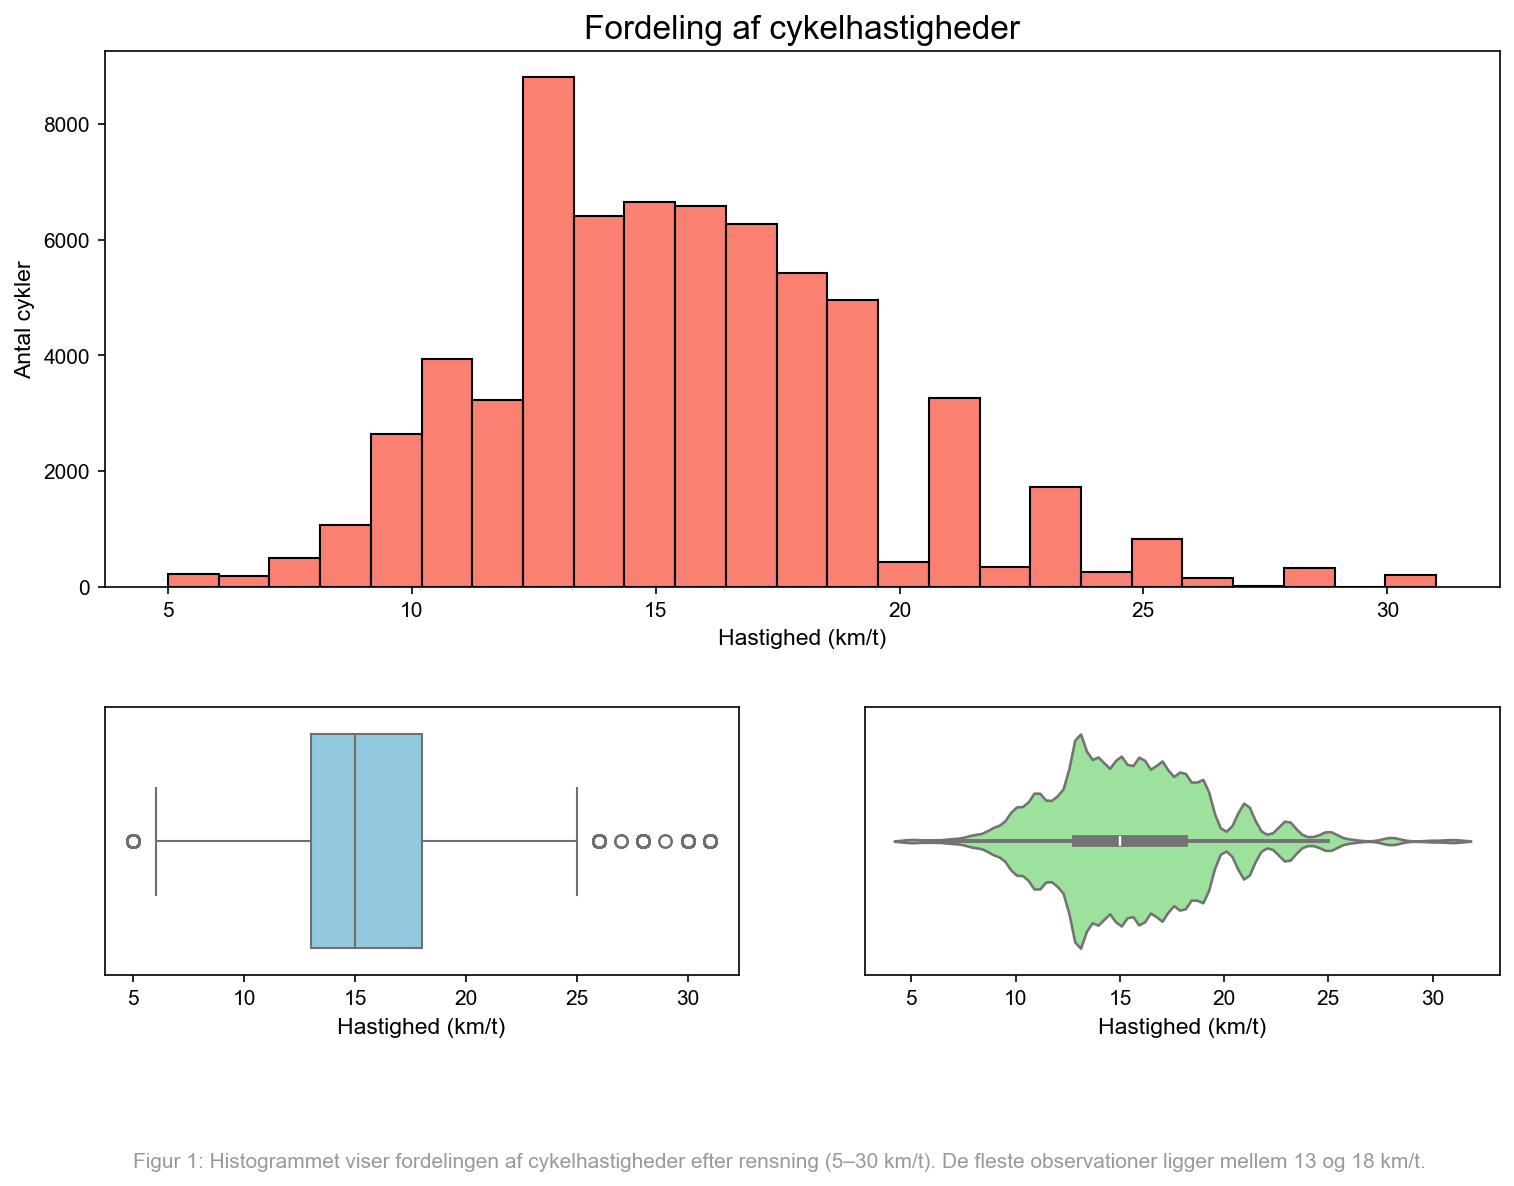

In [126]:
# The data I need for the plots
data = cykelhastighed["Hastighed"]

# Use GridSpec from matplotlib.gridspec
fig = plt.figure(figsize=(12, 8))
grid = gridspec.GridSpec(2, 2, height_ratios=[4, 2], hspace=0.3)

# Header settings
fontd = {'fontsize': 16, 'color': 'black'}

# Histogram (top, spanning both columns)
ax_hist = fig.add_subplot(grid[0, :])
ax_hist.hist(data, bins=25, edgecolor="black",  color="salmon")
ax_hist.set_xlabel("Hastighed (km/t)")
ax_hist.set_ylabel("Antal cykler")
ax_hist.set_title("Fordeling af cykelhastigheder", fontdict=fontd)

# Boxplot (bottom left)
ax_box = fig.add_subplot(grid[1, 0])
sns.boxplot(x=data, ax=ax_box, color="skyblue")
ax_box.set_xlabel("Hastighed (km/t)")
ax_box.set_yticks([])

# Violin plot (bottom right)
ax_violin = fig.add_subplot(grid[1, 1])
sns.violinplot(x=data, ax=ax_violin, inner="box", color="lightgreen")
ax_violin.set_xlabel("Hastighed (km/t)")
ax_violin.set_yticks([])

# Caption below figure
fig.text(
    0.5, -0.05,   # x=0.5 centers it, y=-0.05 places below the plot
    "Figur 1: Histogrammet viser fordelingen af cykelhastigheder "
    "efter rensning (5–30 km/t). De fleste observationer ligger "
    "mellem 13 og 18 km/t.",
    ha="center", fontsize=10, color="grey", alpha=0.8
)

plt.show()


## Definition: LOWESS (Locally Weighted Scatterplot Smoothing)
LOWESS er en **ikke-parametrisk regressionsmetode**, der bruges til at finde en glat kurve gennem et spredt datasæt uden at antage en bestemt funktionel form (som fx lineær eller eksponentiel).  

Idéen er at tilpasse en lokal regression omkring hvert punkt $x_0$ ved at vægte nabopunkterne efter deres afstand til $x_0$.  

---

## Matematikken bag LOWESS
1. **Lokalt vindue**  
   For hvert punkt $x_0$ vælges et nabolag af punkter $x_i$ inden for en afstand $d(x_0)$ (bestemt af parameteren *frac*).

2. **Vægte (tricube-kernen)**  
   Punkter tæt på $x_0$ får høj vægt, mens punkter længere væk får lav vægt. Vægten defineres som
   $$
   w_i(x_0) = 
   \begin{cases}
     \big(1 - |(x_i - x_0)/d(x_0)|^3 \big)^3, & |x_i - x_0| < d(x_0), \\
     0, & \text{ellers.}
   \end{cases}
   $$

3. **Lokal vægtet regression**  
   I vinduet løses en vægtet lineær regression:
   $$
   \min_{\beta_0, \beta_1} \sum_i w_i(x_0)\,\big(y_i - (\beta_0 + \beta_1 x_i)\big)^2
   $$
   og værdien i $x_0$ beregnes som $\hat{y}(x_0) = \beta_0 + \beta_1 x_0$.

4. **Glattet kurve**  
   Gentag for mange $x_0$ og forbind punkterne, hvilket giver en glat kurve.

---

#### LOWESS er velegnet fordi:
- Den fanger den **generelle tendens** (svagt stigende $v$ med stigende $q$).  
- Den **nedtoner outliers**, da fjerne punkter får vægt nær nul.  
- Den giver en **glat, kontinuerlig kurve** i stedet for et hakket gennemsnit.  

---

## Intuition om vægtene
For et givet punkt $q_0$:
- Punkter med $q_i$ tæt på $q_0$ får $w_i \approx 1$.  
- Punkter langt væk får $w_i \approx 0$.  

På den måde “trækker” de nærmeste datapunkter regressionen, og kurven følger datastrukturen uden at blive domineret af støj.  


### 

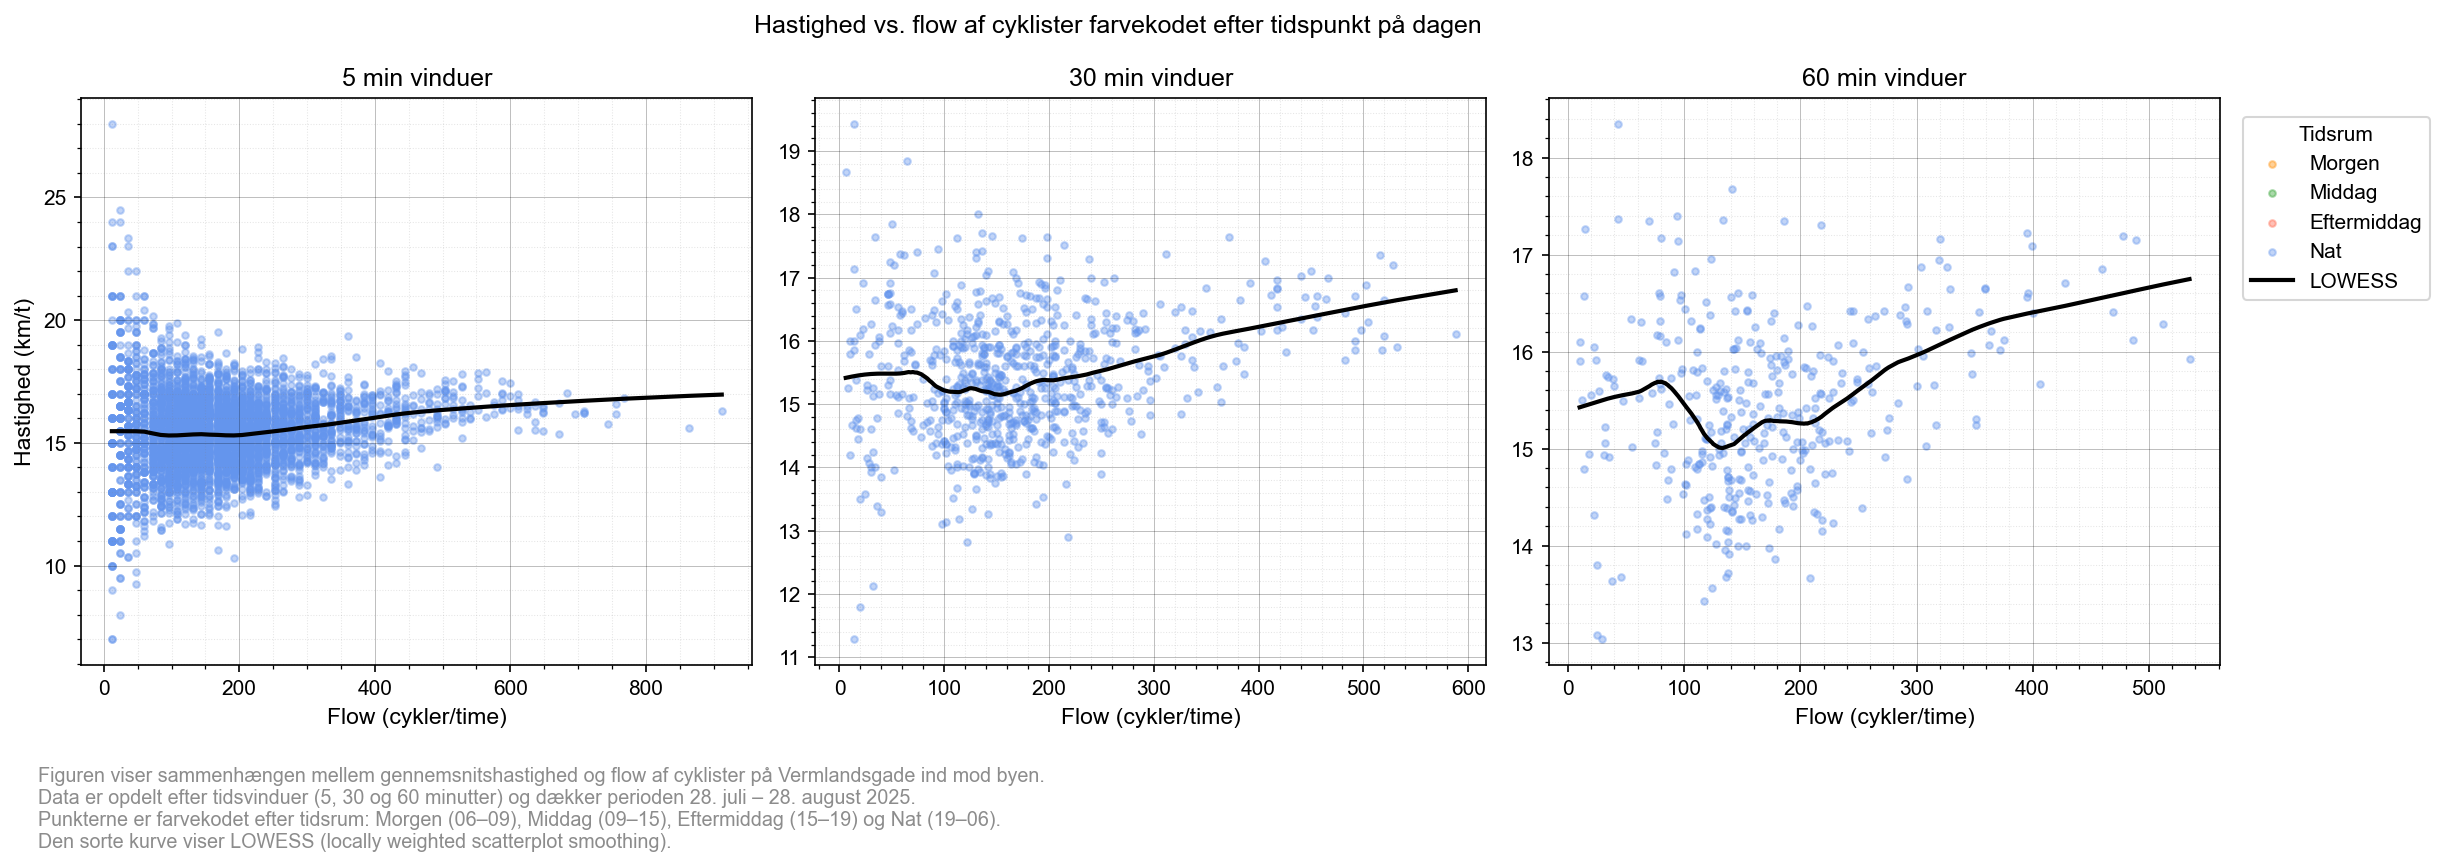

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Create a new dataframe with v (mean speed), n (count), q (flow bikes/hour) + hour for coloring.
def prepare_data(df, freq):
    agg = df["Hastighed"].resample(freq).agg(["mean", "size"])
    agg = agg.rename(columns={"mean": "v", "size": "n"})
    minutes = pd.to_timedelta(freq).total_seconds() / 60.0
    agg["q"] = agg["n"] * (60.0 / minutes)          # cykler/time
    agg["hour"] = agg.index.hour                    # kun sub-daglige frekvenser
    agg["hour"] = agg["hour"] <= 19
    return agg

# labels and color mapping for time of the day 
def time_of_day_label(hour):
    if 6 <= hour < 9:
        return "Morgen"
    elif 9 <= hour < 15:
        return "Middag"
    elif 15 <= hour < 19:
        return "Eftermiddag"
    else:
        return "Nat"

colors = {"Morgen": "darkorange", "Middag": "tab:green", "Eftermiddag": "tomato", "Nat": "cornflowerblue"}

# ---------- plotting ----------
# Frekvens of bikes, FOWESS window size, title of subplot
freqs = [("5min", 0.3, "5 min vinduer"),
         ("30min", 0.3, "30 min vinduer"),
         ("60min", 0.3, "60 min vinduer")]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

for ax, (freq, frac, title) in zip(axes.ravel(), freqs):
    agg = prepare_data(cykelhastighed, freq)

    labels = agg["hour"].apply(time_of_day_label)
    for label, color in colors.items():
        mask = labels == label
        ax.scatter(agg.loc[mask, "q"], agg.loc[mask, "v"], s=10, alpha=0.4, label=label, color=color)

    regression_line = lowess(agg["v"], agg["q"], frac=frac, return_sorted=True)
    ax.plot(regression_line[:, 0], regression_line[:, 1], linewidth=2, color="black", label="LOWESS")

    ax.set_title(title)
    ax.set_xlabel("Flow (cykler/time)")

    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.3, color="black", alpha=0.4)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, color="grey", alpha=0.2)

axes[0].set_ylabel("Hastighed (km/t)")

# fælles legend (baseret på første akse)
# after plotting
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower left",           # anchor to the left edge of the legend box
    bbox_to_anchor=(1.0, 0.6),  # place it just outside the right edge, centered vertically
    borderaxespad=0,
    frameon=True, fancybox=True,
    title="Tidsrum"
)

# leave room on the right for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.suptitle("Hastighed vs. flow af cyklister farvekodet efter tidspunkt på dagen")

fig.text(
    0.02, -0.08,   # x=0.02 puts it near the left margin
    "Figuren viser sammenhængen mellem gennemsnitshastighed og flow "
    "af cyklister på Vermlandsgade ind mod byen.\n"
    "Data er opdelt efter tidsvinduer (5, 30 og 60 minutter) og dækker perioden "
    "28. juli – 28. august 2025.\n"
    "Punkterne er farvekodet efter tidsrum: Morgen (06–09), Middag (09–15), "
    "Eftermiddag (15–19) og Nat (19–06).\n"
    "Den sorte kurve viser LOWESS (locally weighted scatterplot smoothing).",
    ha="left", va="center", fontsize=9.5, color="grey", alpha=0.9
)

plt.tight_layout()
plt.show()


C:\Users\EB41\AppData\Local\Temp\ipykernel_24692\1528515386.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", len(HOURS))


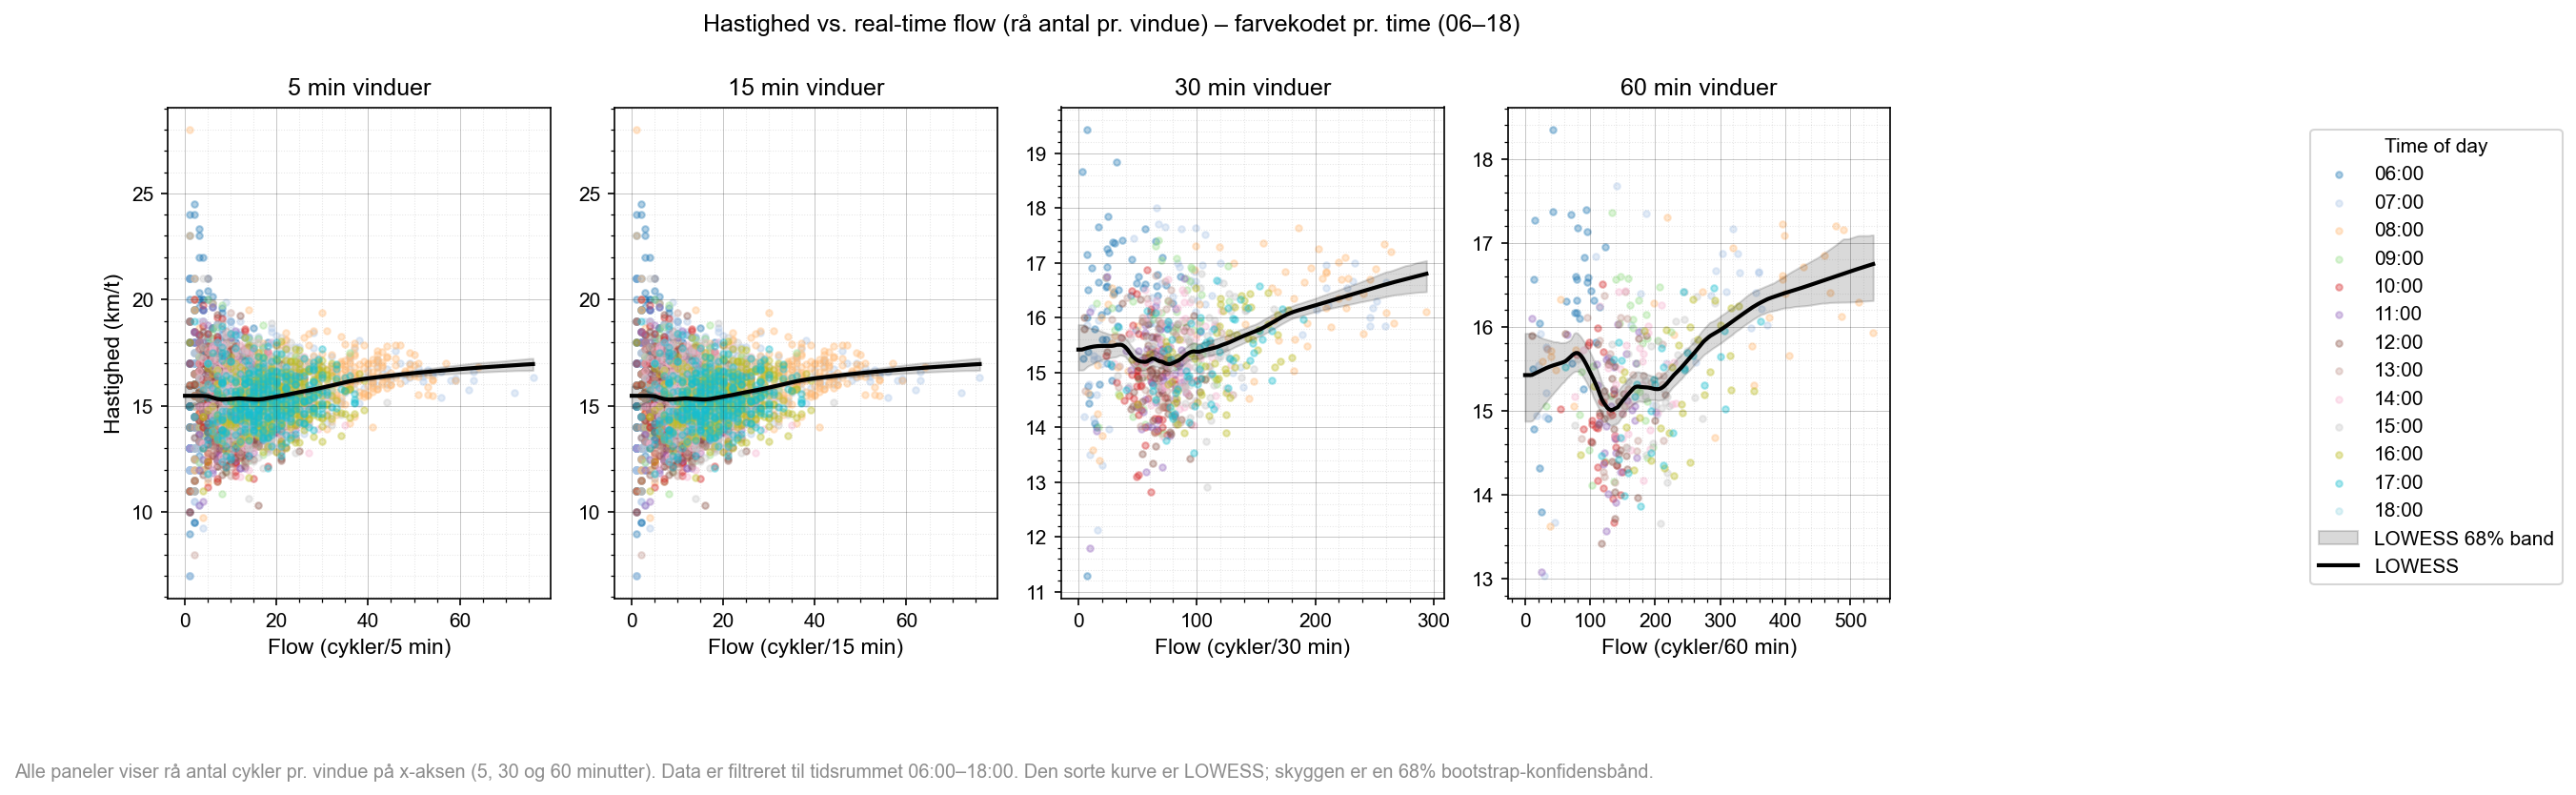

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import cm

# ---------- helpers ----------
def prepare_data(df, freq):
    """Resample -> v (mean speed), n (count per window), q (per-hour flow for reference), hour."""
    agg = df["Hastighed"].resample(freq).agg(["mean", "size"])
    agg = agg.rename(columns={"mean": "v", "size": "n"})
    minutes = pd.to_timedelta(freq).total_seconds() / 60.0
    agg["q"] = agg["n"] * (60.0 / minutes)
    agg["hour"] = agg.index.hour
    return agg

def lowess_with_band(x, y, frac=0.3, grid=None, boot_samples=300, ci=0.68, random_state=42):
    """
    Fit LOWESS and return (x_grid, y_fit, y_lo, y_hi) where [y_lo, y_hi] is a bootstrap CI.
    - x, y: arrays
    - frac: LOWESS smoothing fraction
    - grid: x positions where we want the curve (np.linspace if None)
    - boot_samples: number of bootstrap resamples
    - ci: central mass for band (e.g., 0.68 for ~1σ, 0.95 for ~2σ)
    """
    x = np.asarray(x)
    y = np.asarray(y)
    if grid is None:
        grid = np.linspace(x.min(), x.max(), 200)

    # base fit (sorted pairs)
    base = lowess(y, x, frac=frac, return_sorted=True)
    # interpolate base to grid
    y_fit = np.interp(grid, base[:, 0], base[:, 1])

    # bootstrap fits interpolated to the same grid
    rng = np.random.default_rng(random_state)
    boot_curves = np.empty((boot_samples, grid.size))
    n = x.size
    for b in range(boot_samples):
        idx = rng.integers(0, n, size=n)  # sample with replacement
        sm = lowess(y[idx], x[idx], frac=frac, return_sorted=True)
        boot_curves[b] = np.interp(grid, sm[:, 0], sm[:, 1])

    lower_q = (1 - ci) / 2 * 100
    upper_q = (1 + ci) / 2 * 100
    y_lo = np.percentile(boot_curves, lower_q, axis=0)
    y_hi = np.percentile(boot_curves, upper_q, axis=0)
    return grid, y_fit, y_lo, y_hi

# ---------- daytime filter ----------
df_day = cykelhastighed.between_time("06:00", "18:00")

# hours to show (inclusive)
HOURS = list(range(6, 19))   # 06–18

# color per hour
cmap = cm.get_cmap("tab20", len(HOURS))
hour_colors = {h: cmap(i) for i, h in enumerate(HOURS)}

# ---------- plotting ----------
freqs = [
    ("5min",  0.3, "5 min vinduer",  "Flow (cykler/5 min)"),
    ("5min",  0.3, "15 min vinduer",  "Flow (cykler/15 min)"),
    ("30min", 0.3, "30 min vinduer", "Flow (cykler/30 min)"),
    ("60min", 0.3, "60 min vinduer", "Flow (cykler/60 min)")
]

fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=False)
added_band_label = False  # to only show a single legend entry for the band

for ax, (freq, frac, title, xlabel) in zip(axes.ravel(), freqs):
    agg = prepare_data(df_day, freq)
    agg = agg[agg["hour"].isin(HOURS)]

    # scatter points colored by hour
    for h in HOURS:
        m = agg["hour"] == h
        if not m.any():
            continue
        ax.scatter(
            agg.loc[m, "n"], agg.loc[m, "v"],
            s=10, alpha=0.35, color=hour_colors[h],
            label=f"{h:02d}:00"
        )

    # LOWESS + bootstrap band on a common x-grid
    xgrid, yfit, ylo, yhi = lowess_with_band(
        agg["n"].values, agg["v"].values,
        frac=frac, grid=None, boot_samples=300, ci=0.95, random_state=7
    )
    # band
    band_label = "LOWESS 68% band" if not added_band_label else None
    ax.fill_between(xgrid, ylo, yhi, color="black", alpha=0.15, label=band_label)
    added_band_label = True

    # central LOWESS curve
    ax.plot(xgrid, yfit, linewidth=2, color="black", label="LOWESS")

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.3, color="black", alpha=0.35)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, color="grey", alpha=0.2)

axes[0].set_ylabel("Hastighed (km/t)")

# single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    frameon=True, fancybox=True, title="Time of day",
    ncol=1
)

plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.92])
plt.suptitle("Hastighed vs. real-time flow (rå antal pr. vindue) – farvekodet pr. time (06–18)", y=0.98)
fig.text(
    0.02, -0.08,
    "Alle paneler viser rå antal cykler pr. vindue på x-aksen (5, 30 og 60 minutter). "
    "Data er filtreret til tidsrummet 06:00–18:00. Den sorte kurve er LOWESS; skyggen er en 68% bootstrap-konfidensbånd.",
    ha="left", va="center", fontsize=9.5, color="grey", alpha=0.9
)

plt.show()
